**Task 3**

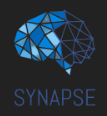

# Unsupervised Learning: Clustering, Dimensionality Reduction, and Association Rules

Unsupervised learning can be broken down into three main tasks:

- **Clustering**  
- **Dimensionality Reduction**  
- **Association Rules**  

Let's explore these topics :))  

Clustering is an unsupervised learning technique used to group similar data points together. It's widely used in applications like customer segmentation, anomaly detection, and more. In this task, we'll explore different clustering algorithms and visualize their results.  

Dimensionality reduction is a technique used to reduce the number of features in a dataset while retaining most of the important information. This helps in better visualization, faster computation, and noise reduction.  

Association rules are used to discover interesting relationships between variables in large datasets. A common example is market basket analysis, where we find products that are frequently bought together.  

In this task, we'll work with the **Online Retail dataset**, which contains transactional data from an e-commerce retailer. We'll use this dataset to:

- Cluster customers based on their purchasing behavior.  
- Reduce feature dimensions for visualization using PCA.  
- Discover associations between products using association rule mining.  


In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# For clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
# For association rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
# For interactive widgets
from ipywidgets import interact
# Misc
import warnings
warnings.filterwarnings("ignore")

Use the Online retail dataset for this task:https://drive.google.com/drive/folders/1jZMLVW7LboD95K-HznZSsVUwrC-k-QOG?usp=sharing

Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("drive/MyDrive/Online_Retail.csv", encoding='latin1') #Add the path in the ""

Understanding the data

In [ ]:
# print 1st few rows of the dataset, its shape and the columns
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# check for null values
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Analyse the Missing Values

From the previous output, we observe:
- `Description` has **1454 missing values** — this is a small amount compared to the total rows. Since association rules require product names, we will **drop rows with missing `Description`**.
- `CustomerID` has **135080 missing values**, which is a large amount. Whether to keep or drop these rows depends on our analysis:
  - If we want to do **customer-level analysis or clustering**, we must have `CustomerID`. In that case, we will **drop rows where `CustomerID` is missing**.
  - If we only want **product-level analysis** (e.g., frequent items), we can keep them.
  
In this task, we will proceed with **customer-level analysis**, so we will **drop rows where `CustomerID` is missing**.


In [ ]:
#Drop the rows with missing\null values
df = df.dropna()
#Re-check the shape and missing values
print(df.shape)
df.isna().sum()

(406829, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
# Remove rows with negative or zero Quantity
df = df[df['Quantity'] > 0]
# Remove rows with zero or negative UnitPrice
df = df[df['UnitPrice'] > 0]
# Remove cancelled invoices (those starting with 'C')
df = df[~df['InvoiceNo'].str.startswith('C')]

In [ ]:
# Verify there are no negative values left
print(df.info())
# Quick summary after cleaning
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB
None


,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [ ]:
# Check how many duplicate rows exist
df.duplicated().sum()

np.int64(5192)

In [ ]:
# Drop duplicate rows
df = df[~df.duplicated()]
# Verify again
df.duplicated().sum()

np.int64(0)

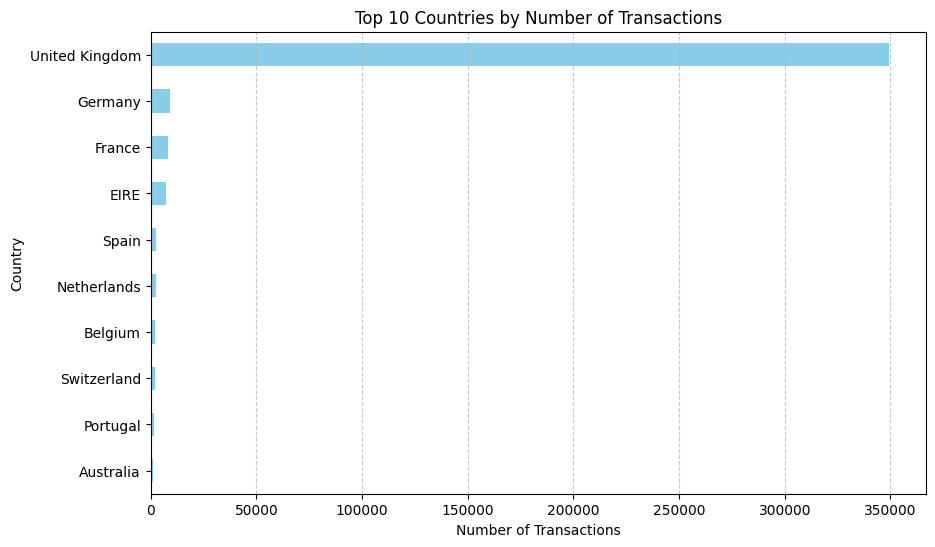

In [ ]:
# Identify the top 10 countries with the highest number of transactions
country_transactions = df.Country.value_counts().head(10)
# Hint: Use a **horizontal bar chart** to visualize the results.
plt.figure(figsize=(10,6))
country_transactions.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.title('Top 10 Countries by Number of Transactions')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Pre-Processing the data for PCA and clustering

In [ ]:
#Create a new TotalAmount column(Quantity * Unit price)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
# Aggregate numeric data at the customer level
customer_df = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalAmount': 'sum'
}).reset_index()

# Keep only numeric columns for PCA

In [ ]:
#Standardize the numeric features
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(customer_df[['Quantity', 'TotalAmount']]),columns=['Quantity', 'TotalAmount'])
scaled_data.head()

,Quantity,TotalAmount
0,14.480825,8.363010
1,0.251903,0.251699
2,0.228702,-0.027988
3,-0.110379,-0.032406
4,-0.196438,-0.190812


Now that you have understood how to preprocess data for PCA through Online Retail dataset, we will apply similar steps to a new dataset: the Customer dataset.

This will help reinforce your understanding of dimensionality reduction and Clustering, while working with a dataset that is easier to visualize in 2D and 3D.

From this point onward, we will use the Customer_Data dataset:https://drive.google.com/drive/folders/1jZMLVW7LboD95K-HznZSsVUwrC-k-QOG?usp=sharing

In [ ]:
# Load the dataset
df_2= pd.read_csv("drive/MyDrive/Customer_Data.csv") # Continue with the routine

In [ ]:
#Check for missing values
df_2.isna().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONE_OFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONE_OFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


In [ ]:
#Drop CUST_ID (identifier, not useful for PCA)
df_2 = df_2.drop('CUST_ID', axis=1)

In [ ]:
#Handle missing values if needed
# Option: fill missing values with median (common in financial datasets)
df_2 = df_2.fillna(df_2.median())
df_2.isna().sum()

,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONE_OFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONE_OFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,0


Explain
Why did we fill the missing values in this dataset instead of dropping them, like we did in the previous dataset?

Answer: the columns with missing values weren't holding numberic data

In [ ]:
#Standardize numeric features
df_2_scaled = pd.DataFrame(scaler.fit_transform(df_2), columns=df_2.columns)

In [ ]:
#Verify scaled data
df_2_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONE_OFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONE_OFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960378,-0.528979,-0.302400,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688678,0.818642,0.097500,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826100,-0.383805,-0.093293,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826100,-0.598688,-0.228307,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905410,-0.364368,-0.257266,-0.525551,0.36068


# Dimensionality Reduction using PCA - Principal Component Analysis

Ref.: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Theory: https://towardsdatascience.com/the-mathematics-behind-principal-component-analysis-fff2d7f4b643 and https://rlrocha.medium.com/choosing-the-number-of-components-of-principal-component-analysis-36902a887520

Theory + Implementation.: https://youtu.be/OFyyWcw2cyM (Jump to timestamp - 13:50 for PCA implementaion)

Before we start of with this, **explain what PCA is and why is it necessary?**

Answer: PCA is a way of finding which features are providing the more information relative to others. it helps us pick which features to pick, and reducing dimensionality lets our model run faster.

Reduce the number of dimensions using PCA,

Hints:
1. Initialise instance of PCA and set *n_components* to 0.9 and *random_state* to 20.
2. Fit X_scaled over the PCA instance created
3. Transform X_scaled over the fitted PCA instance and store it in a variable named data_pca.

In [ ]:
#Code here
pca = PCA(n_components=0.9, random_state=20)
pca.fit(df_2_scaled)
data_pca = pca.transform(df_2_scaled)

In [ ]:
# Check the shape of the transformed data
data_pca.shape
#If everything's correct should print (8950,10)

(8950, 10)

Go through these and display the explained_variance_ratio_ and plot the same

Ref: https://saturncloud.io/blog/what-is-sklearn-pca-explained-variance-and-explained-variance-ratio-difference/ and https://www.jcchouinard.com/pca-explained-variance/

In [ ]:
# Explained variance ratio
print(pca.explained_variance_ratio_)

[0.27297671 0.2031378  0.08813182 0.07479524 0.06224729 0.05740056
 0.04883426 0.04299203 0.03798259 0.03080002]


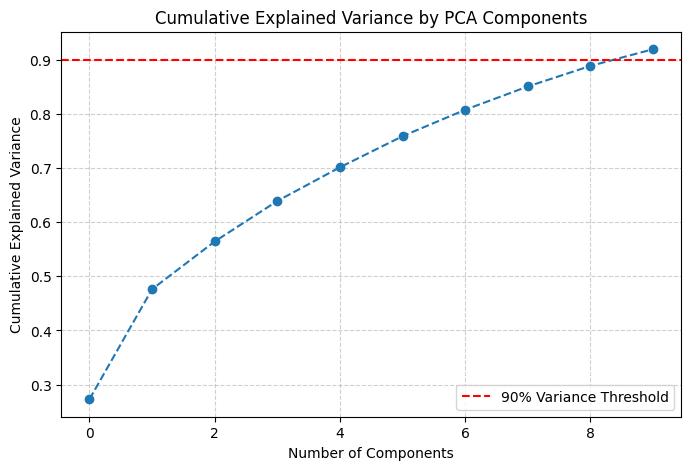

In [ ]:
# Plotting the explained variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

What did you understand by Explained Variance

Answer: explained variance tells us how much of the variance in all of the data is explained by that one feature, its formula is eigenvalue/sum of eigenvalues of all features where eigen value represents the variance captured by that feature

# K-Means Clustering (Partition-Based Clustering)

K-means clustering is an essential partitioning algorithm used to categorize a dataset into 'k' distinct, non-overlapping clusters. Each data point is assigned to the cluster with the nearest mean or centroid, symbolizing the cluster's center. The primary goal of the algorithm is to minimize the sum of squared distances between data points and their respective cluster centroids.

For an in-depth exploration of K-means clustering, you can refer to this comprehensive article on Analytics Vidhya: [Comprehensive Guide to K-means Clustering](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/).

For a deeper understanding of the mathematical underpinnings of K-means clustering, Wikipedia is a valuable resource. You can explore the Wikipedia page on K-means clustering for a detailed description: [K-means Clustering Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering). This will help you grasp the mathematical intricacies of the algorithm and its applications in machine learning.

Here are some more resources to help you understand these concepts in depth:https://www.youtube.com/watch?v=4b5d3muPQmA

2D Visualization


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from ipywidgets import interact

# Function to perform K-Means and plot clusters
def kmeans_clustering(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data_pca)

    plt.figure(figsize=(8,6))
    # Plot the first 2 principal components
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolors='k', alpha=0.7)
    # Plot centroids
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=200, c='red', marker='X', label='Centroids')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'K-Means Clustering ({num_clusters} clusters)')
    plt.legend()
    plt.show()

# Interactive widget to choose number of clusters
interact(kmeans_clustering, num_clusters=(1, 10, 1))


interactive(children=(IntSlider(value=5, description='num_clusters', max=10, min=1), Output()), _dom_classes=(…

<function __main__.kmeans_clustering(num_clusters)>

3D Visualization

In [ ]:
def kmeans_3d_clustering(num_clusters):
    kmeans_3d = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_3d_labels = kmeans_3d.fit_predict(data_pca)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=kmeans_3d_labels, cmap='viridis', edgecolors='k')
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_zlabel('Feature 3 (Standardized)')
    ax.set_title('Kmeans Clustering (3D)')
    plt.show()

interact(kmeans_3d_clustering, num_clusters=(1, 6, 1))

interactive(children=(IntSlider(value=3, description='num_clusters', max=6, min=1), Output()), _dom_classes=('…

<function __main__.kmeans_3d_clustering(num_clusters)>

# Elbow Point

The "elbow point" is a concept often used in the context of K-means clustering to help determine the optimal number of clusters (k) for a given dataset. It is a graphical method that can assist data analysts and machine learning practitioners in finding an appropriate value for k when applying K-means clustering.

The rationale behind the elbow point method is that as you increase the number of clusters (k), the sum of squared distances will generally decrease because data points will be closer to their respective cluster centroids. However, beyond a certain point, subdividing the data into more clusters doesn't provide significant improvements in reducing the sum of squared distances. The elbow point represents that optimal trade-off between the number of clusters and the compactness of each cluster.

It's important to note that the elbow point method is a heuristic and not a foolproof method for determining the ideal k value. In some cases, the elbow point may not be very pronounced, making it challenging to choose the best k. Additionally, the choice of k should also consider domain knowledge and the specific goals of your analysis.


For a clearer and more intuitive explanation of this topic, you can refer to the following video::https://www.youtube.com/watch?v=5shTLzwAdEc (Jump to timestamp 14:28 for elbow method)

Elbow Method to determine the number of clusters to be formed:


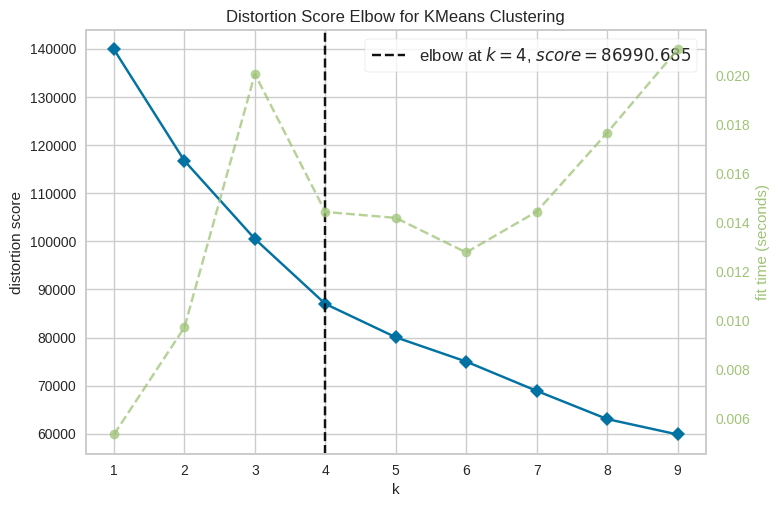

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

print('Elbow Method to determine the number of clusters to be formed:')

Elbow_M = KElbowVisualizer(KMeans(random_state=42), k=(1, 10))
Elbow_M.fit(data_pca)
Elbow_M.show()


# Agglomerative Clustering

It is a hierarchical clustering algorithm used in unsupervised machine learning and data analysis. It is a "bottom-up" or "agglomerative" approach to clustering, where individual data points are initially treated as their own clusters and then progressively merged into larger clusters based on a similarity or distance metric. The result is a tree-like structure called a dendrogram that represents the hierarchical relationships between clusters.

As always, You can find more detailed information about hierarchical clustering, including agglomerative clustering, in the Wikipedia article on "Hierarchical clustering" at the following link: [Hierarchical Clustering Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering). This is the best resource for hierarchical clustering and it is advisable to go through it twice if possible! :)

More ref: https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

**2 Dimensional Visualization**

In [ ]:
# Function for Agglomerative Clustering
def agglomerative_clustering(num_clusters):
    model = AgglomerativeClustering(n_clusters=num_clusters, linkage='single')
    # Fit Agglomerative Clustering on PCA-reduced data
    labels = model.fit_predict(data_pca)
    # use PCA data for plotting
    # Plot clusters (2D using first 2 principal components)
    plt.figure(figsize=(8,6))
    plt.scatter(data_pca[:, 0], data_pca[:, 1],
                c=labels, cmap='plasma', edgecolors='k', alpha=0.7)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Agglomerative Clustering ({num_clusters} clusters)')
    plt.show()


interact(agglomerative_clustering, num_clusters=(1,10,1))#here as well


interactive(children=(IntSlider(value=5, description='num_clusters', max=10, min=1), Output()), _dom_classes=(…

<function __main__.agglomerative_clustering(num_clusters)>

Similar to classification and regression metrics, we have some [clustering metrics](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics) to evaluate performance.

We wll explore one of them: [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Perform Agglomerative Clustering with 3 clusters
agglo = AgglomerativeClustering(n_clusters=3, linkage='average')
labels = agglo.fit_predict(df_2_scaled)  # or use data_pca if you want PCA-reduced data

# Calculate Silhouette Score
silhouette = silhouette_score(df_2_scaled, labels)  # or data_pca
print("Silhouette Score for 3 clusters:", silhouette)


Silhouette Score for 3 clusters: 0.8126048615490263


Explain Silhoutte score:

silhoutte score measures how good a point sits in a cluster, score close to 1 means its very close to the points of its cluster, 0 means its between clusters, negative means its closer to points of other cluster than its own
Look into any 2 other metrics and give a brief explanation.

Do it here :)

**3 Dimensional Visualization**

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Function for 3D Agglomerative Clustering
def agglomerative_3d_clustering(num_clusters):
    # Fit Agglomerative Clustering

    # using PCA data
    clustering = AgglomerativeClustering(n_clusters=num_clusters)
    labels = clustering.fit_predict(data_pca)
    # 3D plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        data_pca[:, 0],
        data_pca[:, 1],
        data_pca[:, 2],
        c=labels,
        cmap='rainbow',
        s=50
    )

    ax.set_title(f'Agglomerative Clustering (k={num_clusters}) in 3D')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    plt.show()

# Interactive widget
interact(agglomerative_3d_clustering, num_clusters=(2,10,1))#fill here


interactive(children=(IntSlider(value=6, description='num_clusters', max=10, min=2), Output()), _dom_classes=(…

<function __main__.agglomerative_3d_clustering(num_clusters)>

Look into what dendrograms are and plot them here.

Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

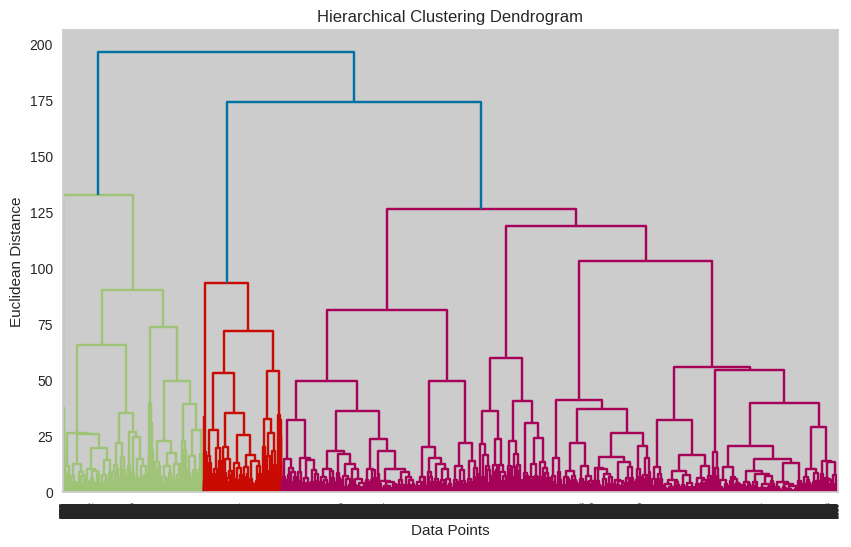

In [ ]:
#plot here
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(data_pca, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

# DBSCAN Clustering

DBSCAN, which stands for Density-Based Spatial Clustering of Applications with Noise, is a popular density-based clustering algorithm in unsupervised machine learning. It is particularly useful for discovering clusters of arbitrary shapes in datasets with varying levels of data density. DBSCAN is known for its ability to handle noise and outliers effectively.

As always, You can find additional information about how DBSCAN clustering works in the following article on Analytics Vidhya:

[How DBSCAN Clustering Works](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/#:~:text=DBSCAN%20is%20a%20density%2Dbased,points%20into%20a%20single%20cluster.)

This article provides a detailed explanation of DBSCAN, including its underlying concepts, the role of epsilon (ε) and minimum points (MinPts), and practical examples of how to use DBSCAN for clustering. It's a valuable resource for gaining a deeper understanding of the algorithm with Wikipedia as the side resource.

Take a look at this short video to gain a better understanding of the concept:https://www.youtube.com/watch?v=RDZUdRSDOok

**2 Dimensional Visualization**

In [ ]:
# Perform DBSCAN clustering with interactive widget
def dbscan_clustering(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data_pca)#code here

    #plot here
    plt.figure(figsize=(8,6))
    plt.scatter(
        data_pca[:, 0],
        data_pca[:, 1],
        c=dbscan_labels,
        cmap='rainbow',
        s=50
    )
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

# Interactive widget
interact(dbscan_clustering, eps=(0.1,5.0,0.1),min_samples=(2,10,1)) #fill here

interactive(children=(FloatSlider(value=2.5000000000000004, description='eps', max=5.0, min=0.1), IntSlider(va…

<function __main__.dbscan_clustering(eps, min_samples)>

**3 Dimensional Visualization**

In [ ]:
def dbscan_3d_clustering(eps, min_samples):
    #Write the complete function yourself
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data_pca)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        data_pca[:, 0],
        data_pca[:, 1],
        data_pca[:, 2],
        c=dbscan_labels,
        cmap='rainbow',
        s=50
    )

    ax.set_title(f'DBSCAN Clustering (eps={eps:.2f}, min_samples={min_samples})')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    plt.show()
# Interactive widget
interact(dbscan_3d_clustering, eps=(0.1,5.0,0.1),min_samples=(2,10,1))


interactive(children=(FloatSlider(value=2.5000000000000004, description='eps', max=5.0, min=0.1), IntSlider(va…

<function __main__.dbscan_3d_clustering(eps, min_samples)>

After performing K-Means and Agglomerative clustering on the dataset, what differences and similarities did you notice between the two methods? What insights did you gain from the cluster patterns?

Answer: agglomerative clustering is slower than k-means i could feel the difference with the interactive widgets, the clusters in agglomerative dont care about no. of clusters given if the linkage is avg single or complete

# **Bonus: To be done only if you have completed the above tasks.**

In this task, we covered clustering and Dimensionality reduction. But still, one aspect of Unsupervised Learning is left to be covered- **Association rules**. Reseach about this topic and mention the different algos that exist.

 Also, look into the functioning of **Spectral Clustering algorithm** and mention it here :)

 The best reseach will be edited and featured on the Synapse Instagram page!!

Once you’ve completed all the tasks, feel free to make your submission even more impressive by adding sample code implementations or practical examples that demonstrate these algorithms in action.

# **End of Task**

> ©DJS Synapse 2025 - 2026